# 2.1.2 Generating alternatives

In this file the MOEA optimization algorithm is used to search through the lever space in order to find promising policies.

The optimization relies on the *platypus-opt* library.

- Define constraints
- Create multiple seeds
- Create reference set
- Check of Convergence

- Evt different reference set? > moet gebruikt worden op basis van dike_model_optimization

dike_model_optimization is het bestand dat het model runt voor toepassing MOEA

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional(state where it is impossible to make any idividual better off without making someone else worse off, best possible outcome for all parties involved) on a reference scenario (evaluated and compared to this benchmark. Eigenlijk een nul scenario maarwaar wel external conditions vastgelegd zijn). These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates.

## 1. Defining objectives and running model
For each outcome of interest it is defined whether the objective is to maximize or minimize it.

The objectives follow from the problem formulation (2): - defined in problem_formulation.py
- Expected damages
- Dike investment costs
- RfR costs: minimize
- Evacuation costs
- Casualties

In this model, all objectives are seen as costs, and have to be minimized. This minimization is defined in *problem_formulation.py*

Model is run with the "optimize" function. Other kwargs are defined here:
- algorithm: $\epsilon$-NSGA2 (default)
- nfe: number of function evaluations (determine conversion)
- Searchover: levers
- Reference: a scenario (worst case? -> hoe te bepalen??)
- Constraints
- Epsilons: epsilon distance

In [6]:
#Remove unused imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, SequentialEvaluator)


from problem_formulation import get_model_for_problem_formulation

#import CSV files generated in dike_model_optimization
results = pd.read_csv('data/output_data/results_optimization_10000nfe.csv')
convergence = pd.read_csv('data/output_data/convergence_optimization_10000nfe.csv')

#define model
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [7]:
results

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,0,0,1,0,0,0,1,0,0,...,6,4,5,0,0,2.682330e+06,1.917880e+08,115300000.0,28.450822,0.000227
1,1,0,0,0,0,0,0,0,0,0,...,1,3,6,0,0,1.893487e+06,2.240744e+08,0.0,125.632768,0.000140
2,2,1,0,0,0,0,0,1,0,0,...,7,5,5,0,0,0.000000e+00,2.227065e+08,115300000.0,0.000000,0.000000
3,3,0,1,0,0,0,0,0,0,1,...,6,0,4,0,0,9.984953e+07,7.605113e+07,115300000.0,2577.837759,0.037611
4,4,1,1,0,0,0,0,0,1,0,...,2,6,4,0,0,3.301591e+06,1.368699e+08,442300000.0,188.067770,0.000410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,1,0,1,0,0,0,1,1,1,...,1,0,3,0,0,4.813821e+07,5.261001e+07,261300000.0,0.000000,0.058441
252,252,0,0,0,0,0,0,0,1,0,...,1,3,3,0,0,1.064492e+08,1.098739e+08,30700000.0,0.000000,0.105905
253,253,0,0,1,0,0,0,1,1,1,...,0,0,3,0,0,4.902761e+07,3.667233e+07,297900000.0,1235.697166,0.017232
254,254,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,4.245254e+07,3.269490e+07,473000000.0,2053.968743,0.005928


### Check convergence of model

Epsilon progress
-  to see if model converges
- (later) calculate hypervolume - uitleggen wat beide begrippen betekenen

> nette plot toevoegen moet nog
uitkomst: er moeten meer nfe worden gerunt, momenteel geen convergence

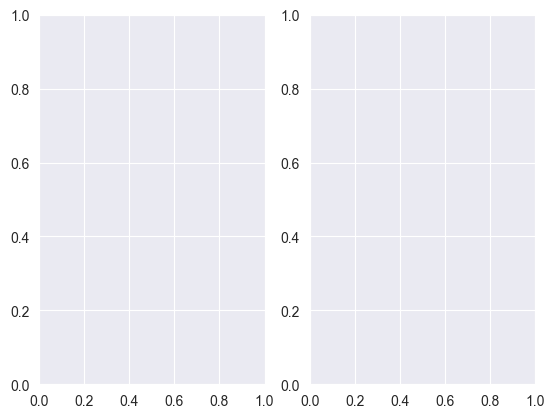

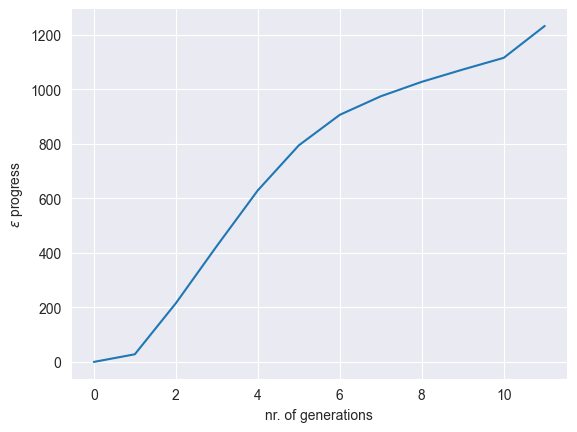

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel("nr. of generations")
ax1.set_ylabel(r"$\epsilon$ progress")
sns.despine()


Calculations of hypervolume

In [12]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated)

In [14]:
archives = ArchiveLogger.load_archives("data/archives/optimization_nfe10000.tar.gz")

In [17]:
from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem
import numpy as np

reference_set = results #compare to reference set of previous results
problem = to_problem(dike_model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem) # calculate the final metric.

hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

AttributeError: 'Pandas' object has no attribute '0_RfR 0'

### Parallel coordinate plots
> eigenlijk eerst resultaten filteren voordat er een plot wordt gemaakt > zo laat je een aantal uitkomsten er al uit.


Uitzoeken welke eisen hier precies aan worden gesteld - Wat moet er gedefinieerd zijn?

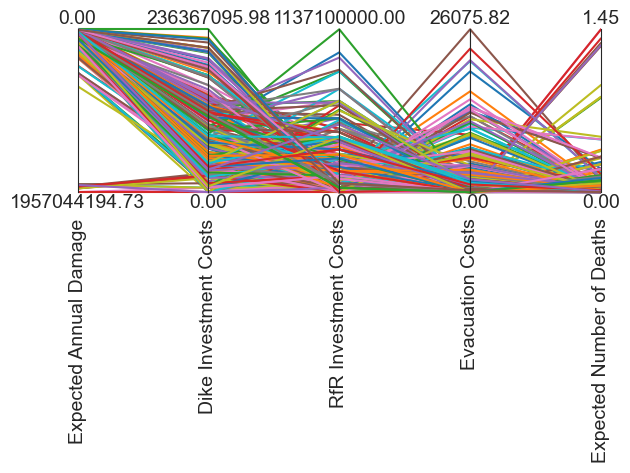

In [21]:
from ema_workbench.analysis import parcoords

data = results.loc[:, [o.name for o in dike_model.outcomes]] #Objectives > selecteren uit resultaten
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths', 'Dike Investment Costs', 'RfR Investment Costs','Evacuation Costs']] = 0
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Expected Annual Damage')
plt.show()